# Example of processing FT-ICR data

First load some libraries

In [1]:
import array
import os.path as op
import numpy as np

import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline

locate the data-set which should be in the repository

In [2]:
ls FTICR-Files/ESI_pos_Ubiquitin_000006.d

ESI_pos_150_3000.m/ desktop.ini*        fid*


so now we can read it

In [3]:
BASE = 'FTICR-Files/ESI_pos_Ubiquitin_000006.d'

In [4]:
F = open(  op.join(BASE, 'fid'), 'rb')
tbuf = F.read()
fid = np.array(array.array('i',tbuf))
F.close()

In [5]:
len(fid)

4194304

In [6]:
fid[1000:1010]

array([ 1137,   125,  1623,   952,  -138,  -366,  -857, -1464, -1604, -1247])

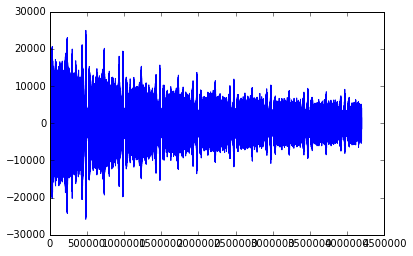

In [7]:
plt.plot(fid)

### Fourier processing 
*small complication*

There are 2 fft packages available
 - `numpy.fft`
   - simple, basic, efficient
 - `scipy.fftpack`
   - slightly faster, more complex

we are going to use `numpy.fft`

In [8]:
sp = np.fft.fft(fid)

In [9]:
print sp[0]
len(sp)

(-2681443+0j)


4194304

In [10]:
# default size of the figures
mpl.rcParams['figure.figsize'] = [10.0,8.0]
# this helps matplotlib to draw the huge vectors we're using (4-8Mpoints)
mpl.rcParams['agg.path.chunksize'] = 100000

/Users/mad/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


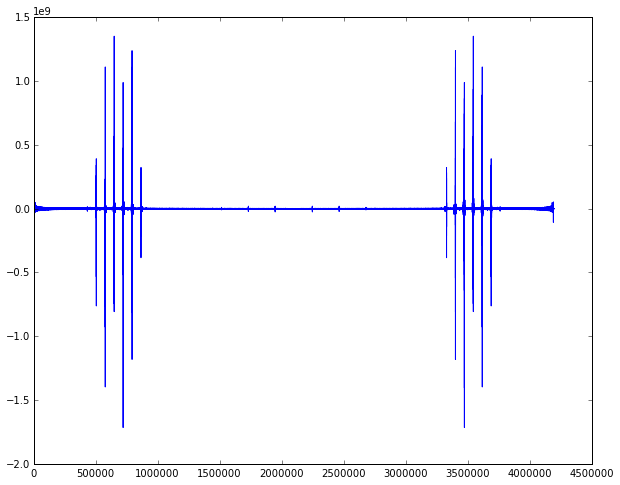

In [11]:
plt.plot(sp)

3 remarks
 - imaginary discarded (eventually silently)
 - phase
 - symetry

1 syntax remark

In [12]:
from numpy.fft import fft, rfft
sp = rfft(fid)
print sp[0]
len(sp)

(-2681443+0j)


2097153

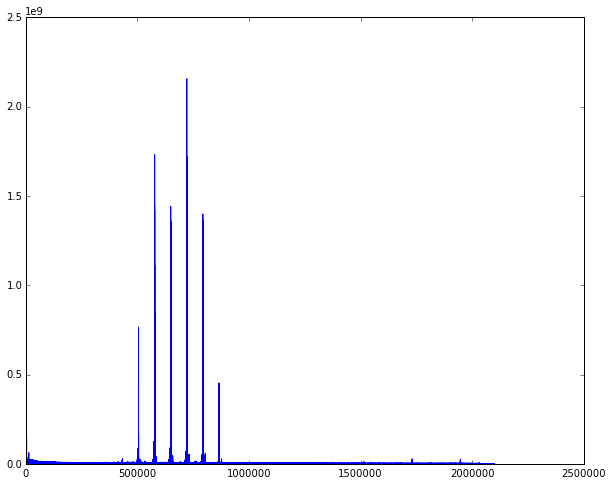

In [13]:
plt.plot(abs(sp))     # absolute value is modulus

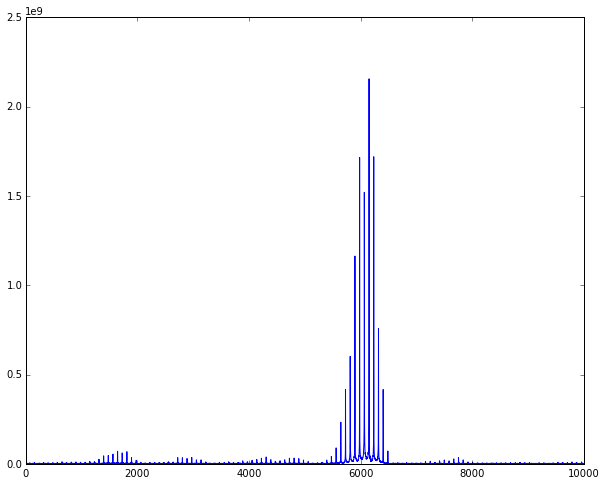

In [14]:
# let's zoom in
plt.plot(abs(sp[715000:725000]))

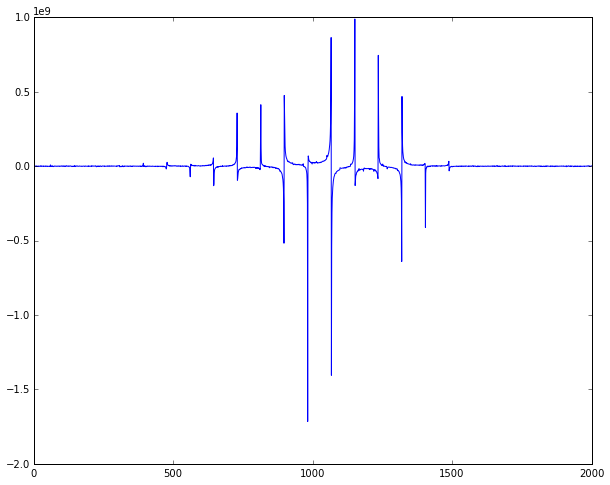

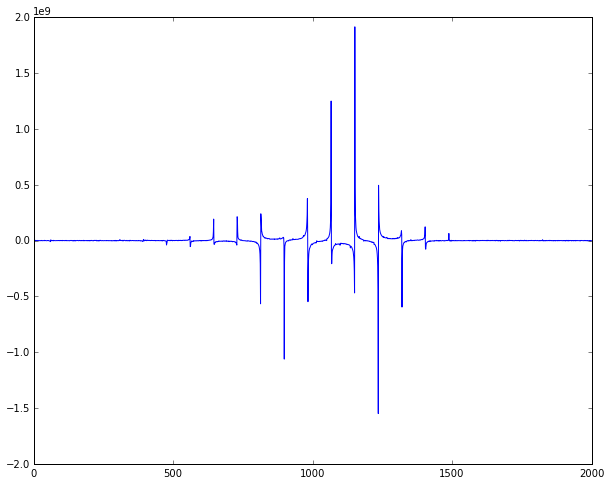

In [15]:
# without the abs() we see the phase rotating
plt.plot(sp[720000:722000])
plt.figure()
# we rotate by 90° the phase
plt.plot(1j*sp[720000:722000])


## 2 possible improvements
 - improved resolution by apodisation
 - recovery of the full resolution by zerofilling
 
 ### apodisation

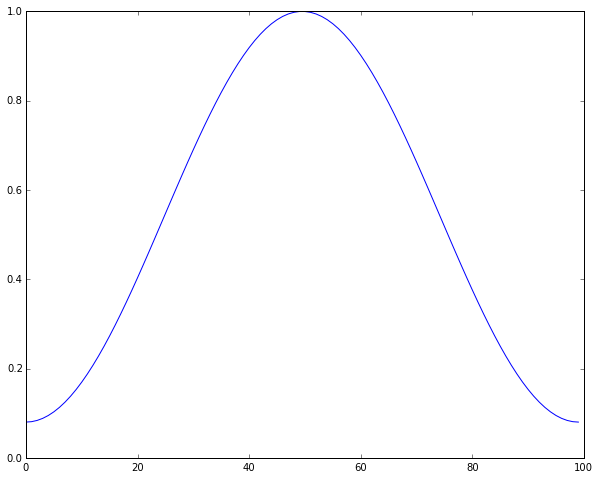

In [16]:
plt.plot(np.hamming(100))


there is also `blackman` `hanning`  `bartlett`...

In [17]:
np.blackman.func_name

'blackman'

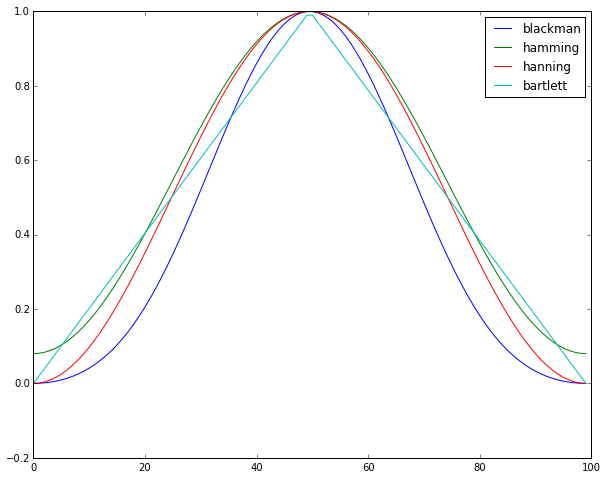

In [18]:
for apod in (np.blackman, np.hamming, np.hanning, np.bartlett):
    plt.plot(apod(100),label=apod.func_name)
plt.legend()


In [19]:
sp2 = rfft( np.hamming(len(fid))*fid )

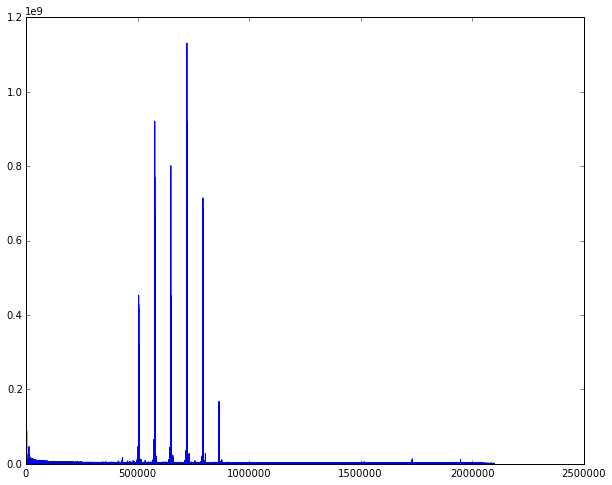

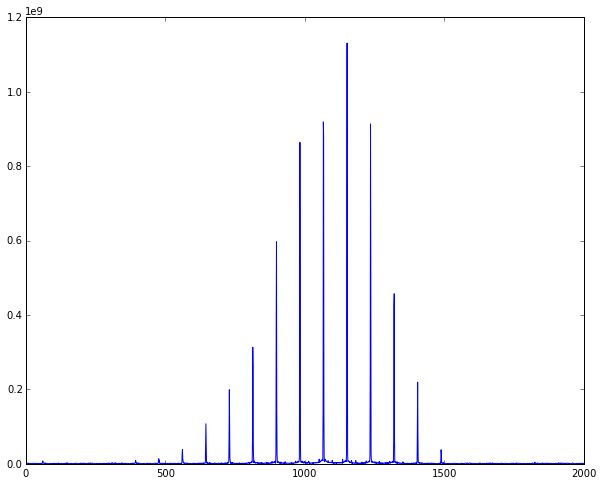

In [20]:
plt.plot(abs(sp2))
plt.figure()
plt.plot(abs(sp2[720000:722000]))

Notice how lineshape is improved, and the isotopic pattern intensities restored

We can superimpose both processing, zooming on a line you can see that FWHM is sligthly worse when apodized.

Theory is 1.5 for hamming window, but does not really show here.

(721050, 721080)

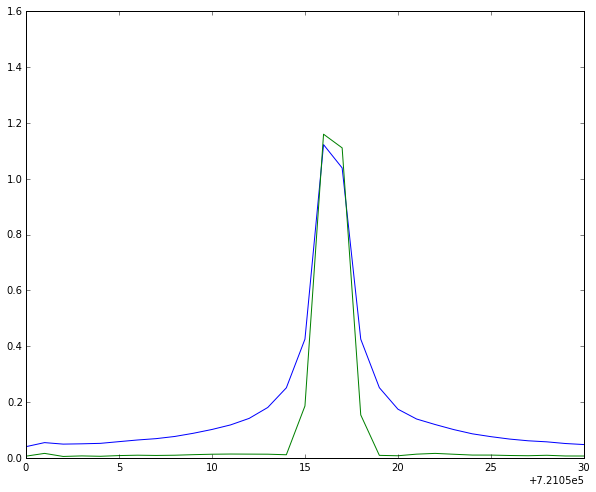

In [21]:
plt.plot(abs(sp)/max(sp))
plt.plot(abs(sp2)/max(sp2))
plt.xlim(721050,721080)

### zerofilling

zerofilling consists in adding zero at the end of the FID to interpolate points in the spectrum and smooth the result

( and an example of slighlty different numpy arithmetics)

In [22]:
n = len(fid)
fidzf = np.zeros(2*n)


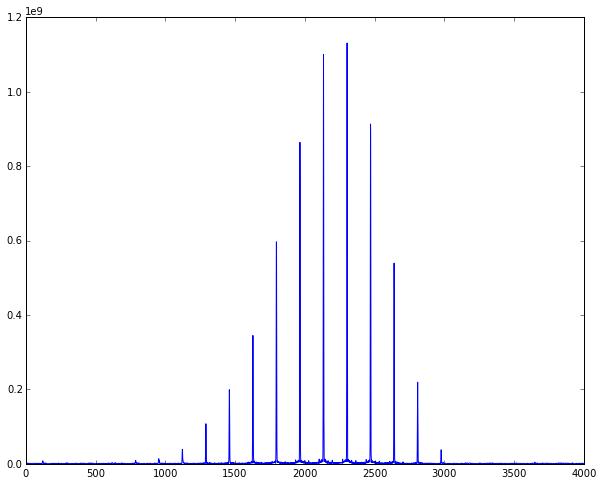

In [23]:
fidzf[:n] = fid[:]
fidzf[:n] *= np.hamming(n)
spzf = abs(rfft( fidzf ))
plt.plot(abs(spzf[2*720000:2*722000]))

lineshape and isotopic pattern intensities further improved !

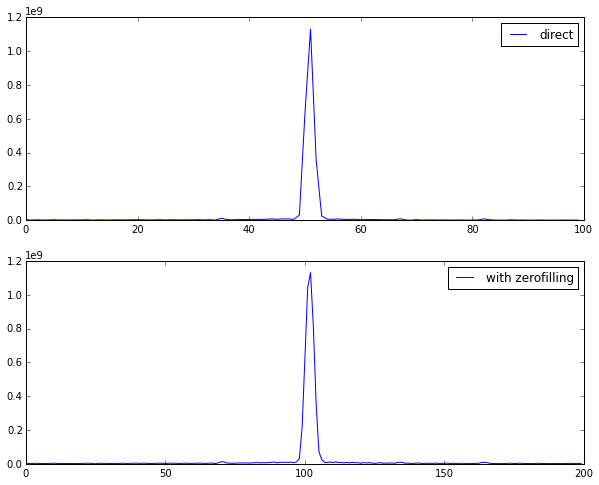

In [24]:
plt.subplot(211)
plt.plot(abs(sp2[721100:721200]), label='direct')
plt.legend()
plt.subplot(212)
plt.plot(abs(spzf[2*721100:2*721200]), label='with zerofilling')
plt.legend()

# m/z Calibration
In FT-ICR, the frequency $f$ depends on the magnetic field $B_o$ the charge $z$ and the mass $m$ :
$$ f = \frac{B_o z}{m} \quad \Rightarrow \quad  m/z = \frac{B_o}{f}$$
We are going to use a sligthly extended equation which takes cares of experimental imperfections:
$$ m/z = \frac{M_1}{M_2+f}$$
where $M_1$ and $M_2$ are constants determined precisely by a calibration procedure

### parameter files
FT-ICR parameters are stored in the .method files

In [25]:
ls 'FTICR-Files/ESI_pos_Ubiquitin_000006.d/ESI_pos_150_3000.m/apexAcquisition.method'

FTICR-Files/ESI_pos_Ubiquitin_000006.d/ESI_pos_150_3000.m/apexAcquisition.method*


# utility
parameter are stored in a XML file, we can look through the file and get the parameters manually, but it is also possible to simply build a dictionary from the entries.

Here a simple mini parser, using standard python library

In [26]:
from xml.dom import minidom
def read_param(filename):
    """
        Open the given file and retrieve all parameters from apexAcquisition.method
        NC is written when no value for value is found
        
        structure : <param name = "AMS_ActiveExclusion"><value>0</value></param>
       
        read_param returns  values in a dictionnary
    """
    xmldoc = minidom.parse(filename)
    
    x = xmldoc.documentElement
    pp = {}
    children = x.childNodes
    for child in children:
        if (child.nodeName == 'paramlist'):
            params = child.childNodes
            for param in params:
                if (param.nodeName == 'param'):
                    k = str(param.getAttribute('name'))
                    for element in param.childNodes:
                       if element.nodeName == "value":
                           try:
                               v = str(element.firstChild.toxml())
                               #print v
                           except: 
                               v = "NC"
                    pp[k] = v
    return pp

In [27]:
pfile = op.join(BASE, 'ESI_pos_150_3000.m', 'apexAcquisition.method')
param = read_param(pfile)
print (param['TD'])

4194304


In [28]:
# print the 10 first entries
print(param.keys()[:10])

['IN_23', 'IN_22', 'IN_21', 'IN_20', 'IN_27', 'IN_26', 'IN_25', 'IN_24', 'VPV2_5', 'VPV2_15']


In [29]:
# we find the parameters in the parameter file
sw = float(param['SW_h_Broadband'])
ml1 = float(param['ML1'])
ml2 = float(param['ML2'])
print('Spectral width: {}'.format(sw) )
print('constant M_1: {}'.format(ml1))
print('constant M_2: {}'.format(ml2))

Spectral width: 625000.0
constant M_1: 184270017.834
constant M_2: 5.03916110231


In [30]:
faxis = np.linspace(0, sw, len(spzf))    # the freq axis from 0 to sw

In [31]:
mzaxis = ml1/(ml2+faxis)    # and the mzaxis

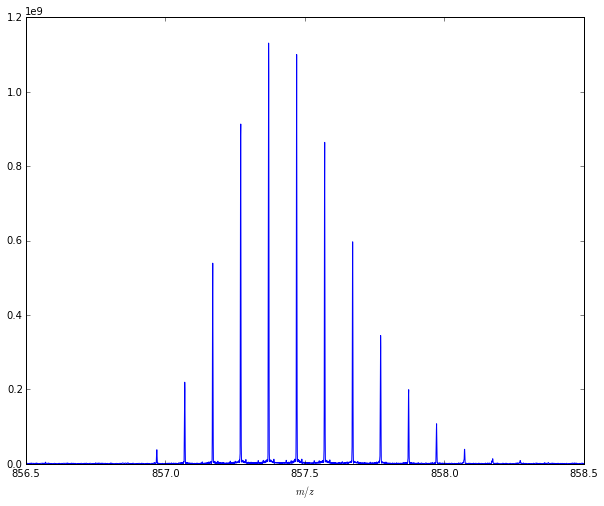

In [32]:
plt.plot(mzaxis, spzf)
plt.xlim(856.5, 858.5)
plt.xlabel("$m/z$")

we can zoom on the monoisotopic peak, and try to determine precisely its value.

We know the theorical mass is 856.969496 (for the $z=10$ state).

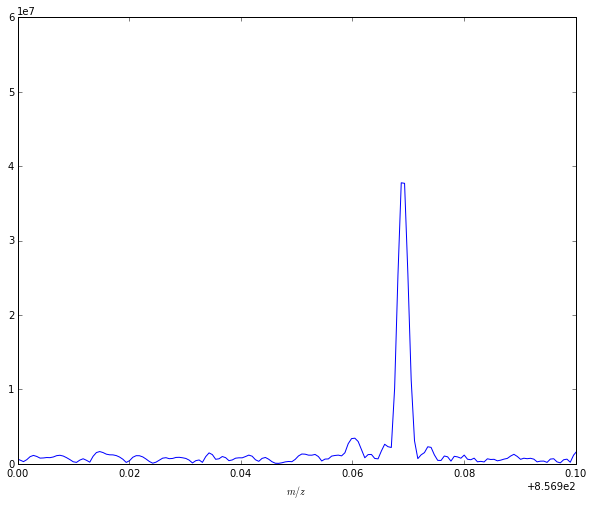

In [33]:
plt.plot(mzaxis, spzf)
plt.xlim(856.9, 857.0)
plt.ylim(0,6E7)
plt.xlabel("$m/z$")

In [34]:
# these functions convert back and forth from index to m/z
def itomz(val, N):
    """transform index to m/z for N points,
    using current ml1 ml2 and sw
    """
    f = sw*val/N
    return ml1/(ml2+f)
def mztoi(m, N):
    """transform m/z to index for N points,
    using current ml1 ml2 and sw
    """
    f = ml1/m - ml2
    return N*f/sw
theo = 856.9694962104804
def ppm(theorical, measured):
    return 1E6*(measured-theorical)/measured

we can compute the vector coordinates of the previous zoom window

start: 1442924  - end: 1443093
maximum is at: 1442977, for m/z: 856.968940676
For an error of -0.648 ppm


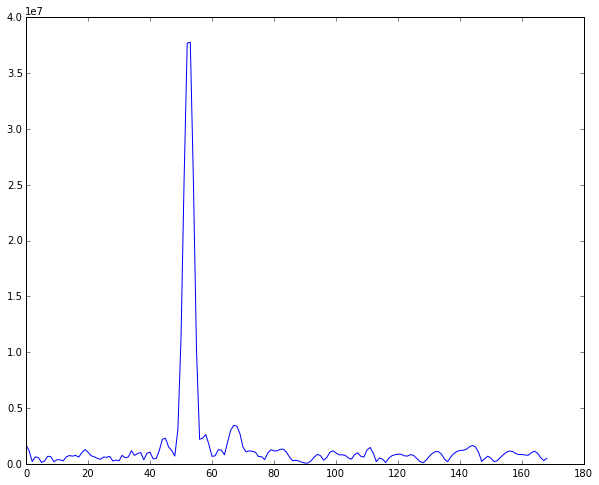

In [35]:
start = int( mztoi(857.0, len(spzf)))
end = int( mztoi(856.9, len(spzf)))
print("start: {}  - end: {}".format(start,end))
plt.plot(spzf[start:end])
top = spzf[start:end].argmax() + start
meas1 = itomz(top,len(spzf))
print("maximum is at: {}, for m/z: {}".format(top,meas1))
print("For an error of {:.3f} ppm".format(ppm(theo, meas1)))

In [36]:
# peak barycenter
bary = 0.0
s = 0
for i in range(-3, +4):
    bary += i*spzf[i+top]
    s += spzf[i+top]
mbary = itomz(bary/s+top, len(spzf))
print ("peak barycenter is at {}".format(mbary))
print("For an error of {:.3f} ppm".format(ppm(theo, mbary)))

peak barycenter is at 856.969219465
For an error of -0.323 ppm


# packing it up
Now we can simply build a function doing all this at once :

In [37]:
import glob
def read_fticr(folder):
    """
    load and process the data Solarix Apex FTICR file found in folder
    uses the calibration from the parameter file
    
    eg:
    spectrum,axis = read_fticr('FTICR/Files/bruker ubiquitin file/ESI_pos_Ubiquitin_000006.d')
    """
    # find and load parameters
    L = glob.glob(op.join(folder,"*","apexAcquisition.method"))
    if len(L)>1:
        raise Exception( "You have more than 1 apexAcquisition.method file in the %s folder, using the first one"%folder )
    elif len(L) == 0: 
        raise Exception( "You don't have any apexAcquisition.method file in the  %s folder, please double check the path"%folder )
    param = read_param(L[0])
    
    # load data
    n = int(param['TD'])
    fidzf = np.zeros(2*n)
    with  open(  op.join(BASE, 'fid'), 'r') as F:  # 'with' a better way of reading a file
        tbuf = F.read(4*int(param['TD']))
        fidzf[:n] = np.array(array.array('i',tbuf)) # [:] is less memory intensive

    # process
    fidzf[:n] *= np.hamming(n)
    spectrum = abs( rfft( fidzf ) )

    # calibrate
    sw = float(param['SW_h_Broadband'])
    ml1 = float(param['ML1'])
    ml2 = float(param['ML2'])
    faxis = np.linspace(0, sw, len(spectrum))    # the freq axis from 0 to sw
    mzaxis = ml1/(ml2+faxis)    # and the mzaxis
    return spectrum, mzaxis


In [38]:
spectrum,axis = read_fticr('FTICR-Files/ESI_pos_Ubiquitin_000006.d')

(200, 2500)

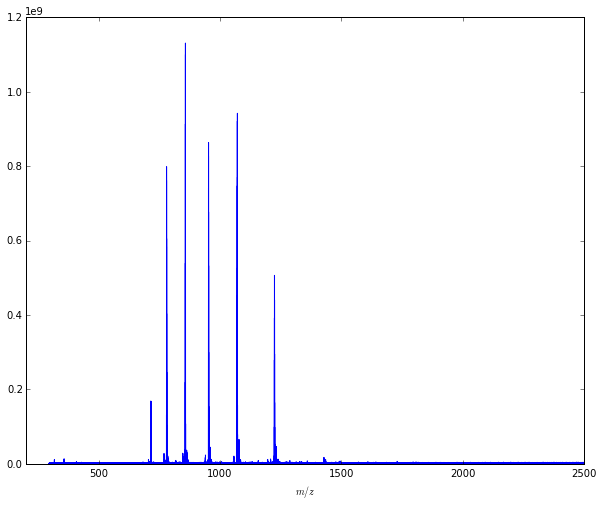

In [39]:
# %matplotlib
plt.plot(axis, spectrum)
plt.xlabel("$m/z$")
plt.xlim(200,2500)

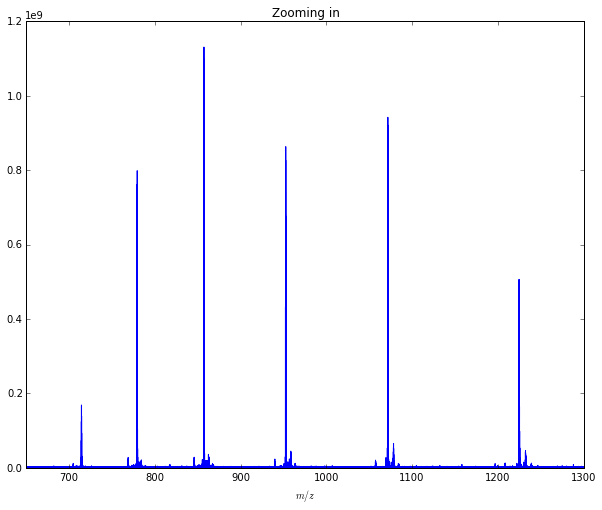

In [40]:
plt.plot(axis, spectrum)
plt.xlabel("$m/z$")
plt.xlim(650,1300)
plt.title("Zooming in")

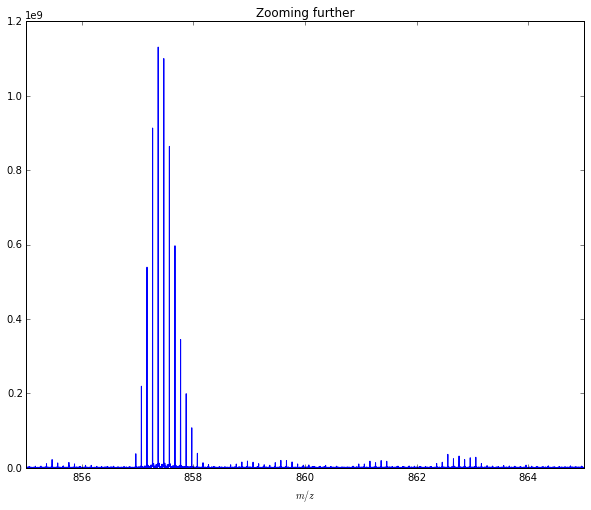

In [41]:
plt.plot(axis, spectrum)
plt.xlabel("$m/z$")
plt.xlim(855,865)
plt.title("Zooming further")

# Doing the same thing with SPIKE

SPIKE is a complete software suite we're building to do this, *and much more*

It is distributed here : https://bitbucket.org/delsuc/spike

However, the program is not fully operational yet, stay tuned !

In [42]:
import sys
sys.path.append('/Users/mad/NPKV2/')  # adapt this to your own set-up
import spike
from spike.File import Solarix
%matplotlib inline


          SPIKE
    Version     : 0.6.4
    Date        : 12-03-2015
Importing plugin << bcorr >>
Importing plugin << Bruker_NMR_FT >>
Importing plugin << Bucketing >>
Importing plugin << DOSY >>
Importing plugin << fastclean >>
Importing plugin << Linear_prediction >>
Importing plugin << Peaks >>
Importing plugin << rem_ridge >>
Importing plugin << sg >>
Importing plugin << test >>
Importing plugin << urQRd >>


In [43]:
File = 'FTICR-Files/ESI_pos_Ubiquitin_000006.d'
dd = Solarix.Import_1D(File)

Dim 1
Axis F1 : FT-ICR axis at 625.000000 kHz,  4194304 real points,  from mz = 3000.000   to m/z =  231.024  R max (M=400) = 2422464

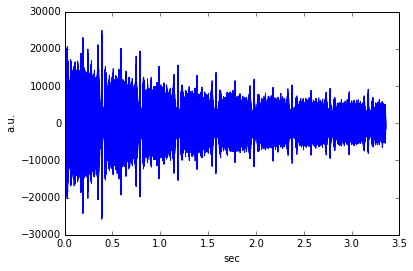

In [44]:
dd.unit = "sec"
dd.display()

Dim 1
Axis F1 : FT-ICR axis at 625.000000 kHz,  4194304 real points,  from mz = 3000.000   to m/z =  231.024  R max (M=400) = 2422464

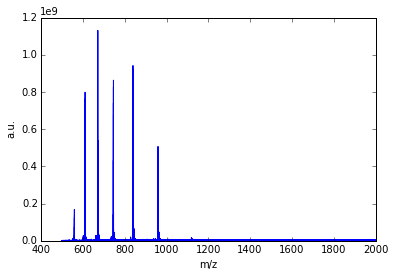

In [45]:
dd.hamming().zf(2).rfft().modulus()
dd.unit = "m/z"
dd.display(zoom=(500,2000))

Dim 1
Axis F1 : FT-ICR axis at 625.000000 kHz,  4194304 real points,  from mz = 3000.000   to m/z =  294.830  R max (M=400) = 3091537

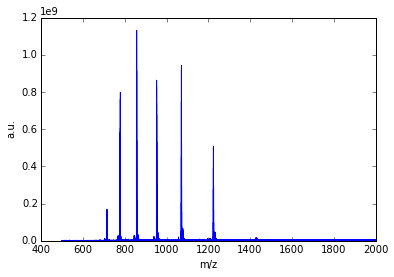

In [46]:
# wrong calibration !
dd.axis1.calibA = float(dd.params["ML1"])
dd.axis1.calibB = float(dd.params["ML2"])
dd.display(zoom=(500,2000))

In [47]:
dd.pp(threshold=1E7)
print ("detected %d peaks"%len(dd.peaks))

10000000.0
detected 709 peaks


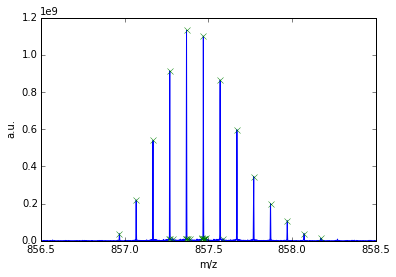

In [48]:
dd.display(zoom=(856.5, 858.5))
dd.display_peaks(zoom=(856.5, 858.5))

In [49]:
p = dd.peaks[603]

In [50]:
p.report()

'603, 603, 1438613.00000, 19899454.35191, 0.00'

In [51]:
p.label = "Peak 103"
p.report()  # in index
p.report(f=dd.axis1.itomz)  # provides in m/z
# string is :
# id, label, m/z, intensity, width (0 if not determined)

'603, Peak 103, 859.56807, 19899454.35191, 0.00'

In [52]:
dd.centroid()
for p in dd.peaks:
    p.label = "%.5f"%(dd.axis1.itomz(p.pos))

/Users/mad/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


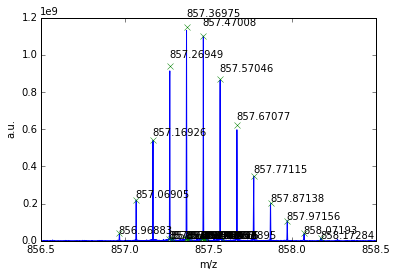

In [53]:
# this switches to a different display mode
dd.display(zoom=(856.5, 858.5))
dd.display_peaks(zoom=(856.5, 858.5), peak_label=True)